* エンティティエンベディング

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pickle

# --- データ読み込み & 前処理 ---
df = pd.read_csv("df_clean_zone_cluster.csv")
df = df[df['pitch_type'].notna() & df['zone'].notna()].copy()
df[['on_1b', 'on_2b', 'on_3b']] = df[['on_1b', 'on_2b', 'on_3b']].fillna(0).astype(int)
df[['on_1b', 'on_2b', 'on_3b']] = df[['on_1b', 'on_2b', 'on_3b']].applymap(lambda x: 0 if x == 0 else 1)
df['runner_str'] = df['on_1b'].astype(str) + df['on_2b'].astype(str) + df['on_3b'].astype(str)
df = df[(df['balls'] <= 3) & (df['strikes'] <= 2)]
df['ball_strike_out'] = df['balls'].astype(str) + df['strikes'].astype(str) + df['outs_when_up'].astype(str)
df['inning_phase'] = df['inning'].apply(lambda x: 'early' if x < 6 else 'late')
df['hand_match'] = (df['stand'] == df['p_throws']).map({True: 'same', False: 'diff'})
df["hand_match_a"] = df['p_throws'].astype(str) + df['stand'].astype(str)
# 並び替え（安全のため）
df['month'] = pd.to_datetime(df['game_date']).dt.month
df['month'] = df['month'].replace({3: 4, 11: 10})  # ここ活かせる
df = df.sort_values(['game_pk', 'at_bat_number', 'pitch_number'])

# シフトして前球取得
df['prev_pitch'] = df['pitch_type'].shift(1)
df['prev_zone'] = df['zone'].shift(1)

# 打席が変わったら無効化
same_at_bat = df['at_bat_number'] == df['at_bat_number'].shift(1)
df['prev_pitch'] = df['prev_pitch'].where(same_at_bat)
df['prev_zone'] = df['prev_zone'].where(same_at_bat)

# 文字列で結合して1カテゴリ変数にまとめる
df['prev_pitch_zone'] = df['prev_pitch'].astype(str) + "_" + df['prev_zone'].astype(str)
df['prev_pitch_zone'] = df['prev_pitch_zone'].fillna("none")

# --- 点差の簡易化とバイン分け ---
df['score_diff'] = df['bat_score'] - df['fld_score']
df['score_diff_bin'] = pd.cut(
    df['score_diff'],
    bins=[-100, -3, -1, 0, 1, 3, 100],
    labels=["behind_large", "behind_small", "even", "lead_small", "lead_mid", "lead_large"]
)

# --- カテゴリ変数の指定 ---
cat_features = [
    'ball_strike_out', 'runner_str', 'inning_phase', 'hand_match',
    'pitcher', 'fielder_2', 'home_team',  'month'
]

# --- ラベルエンコード & テンソル変換 ---
label_encoders = {}
cat_dims = []
X_cat_encoded = []

for col in cat_features:
    le = LabelEncoder()
    encoded_col = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    cat_dims.append(len(le.classes_))
    X_cat_encoded.append(encoded_col)

# --- pickleでラベルエンコーダ保存 ---
with open("label_encoders_embed_final_a_prev.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

X_cat = torch.tensor(list(zip(*X_cat_encoded)), dtype=torch.long)

# --- 目的変数 ---
df = df[df['pitch_type'].notna() & df['zone'].notna()].copy()
df['target'] = df['pitch_type'].astype(str) + '_' + df['zone'].astype(str)
target_encoder = LabelEncoder()
y = torch.tensor(target_encoder.fit_transform(df['target']), dtype=torch.long)
num_classes = len(target_encoder.classes_)

# --- データ分割 ---
X_train, X_val, y_train, y_val = train_test_split(X_cat, y, test_size=0.2, random_state=42)

# --- 基本の域の定義 ---
def emb_dim(n): return max(1, min(50, int(n ** 0.25)))
emb_dims = [emb_dim(dim) for dim in cat_dims]

# --- モデル構築 ---
class EntityEmbeddingModel(nn.Module):
    def __init__(self, cat_dims, emb_dims, out_dim):
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(cat_dim, emb_dim)
            for cat_dim, emb_dim in zip(cat_dims, emb_dims)
        ])
        self.fc_layers = nn.Sequential(
            nn.Linear(sum(emb_dims), 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, out_dim)
        )

    def forward(self, x):
        embedded = [emb(x[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(embedded, dim=1)
        return self.fc_layers(x)

    def predict_proba(self, x):
        logits = self.forward(x)
        return torch.softmax(logits, dim=1)

# --- 実行 ---
model = EntityEmbeddingModel(cat_dims, emb_dims, num_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses = []
val_losses = []

for epoch in range(300):
    model.train()
    logits = model(X_train)
    loss = loss_fn(logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_logits = model(X_val)
        val_loss = loss_fn(val_logits, y_val)
        val_losses.append(val_loss.item())
        val_preds = torch.argmax(model.predict_proba(X_val), dim=1)
        acc = (val_preds == y_val).float().mean().item()

    print(f"Epoch {epoch+1}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}, Val Acc = {acc:.4f}")

# --- 基づく基礎ベクトルの出力 & 保存 ---
embedding_weights = {}
for i, feat in enumerate(cat_features):
    emb = model.embeddings[i].weight.data.cpu().numpy()
    for j in range(emb.shape[0]):
        embedding_weights[f"{feat}_{j}"] = emb[j]

embedding_df = pd.DataFrame.from_dict(embedding_weights, orient='index')
embedding_df.to_csv("trained_entity_embeddings_nomal.csv")
print("\n✅ 埋め込み保存完了")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


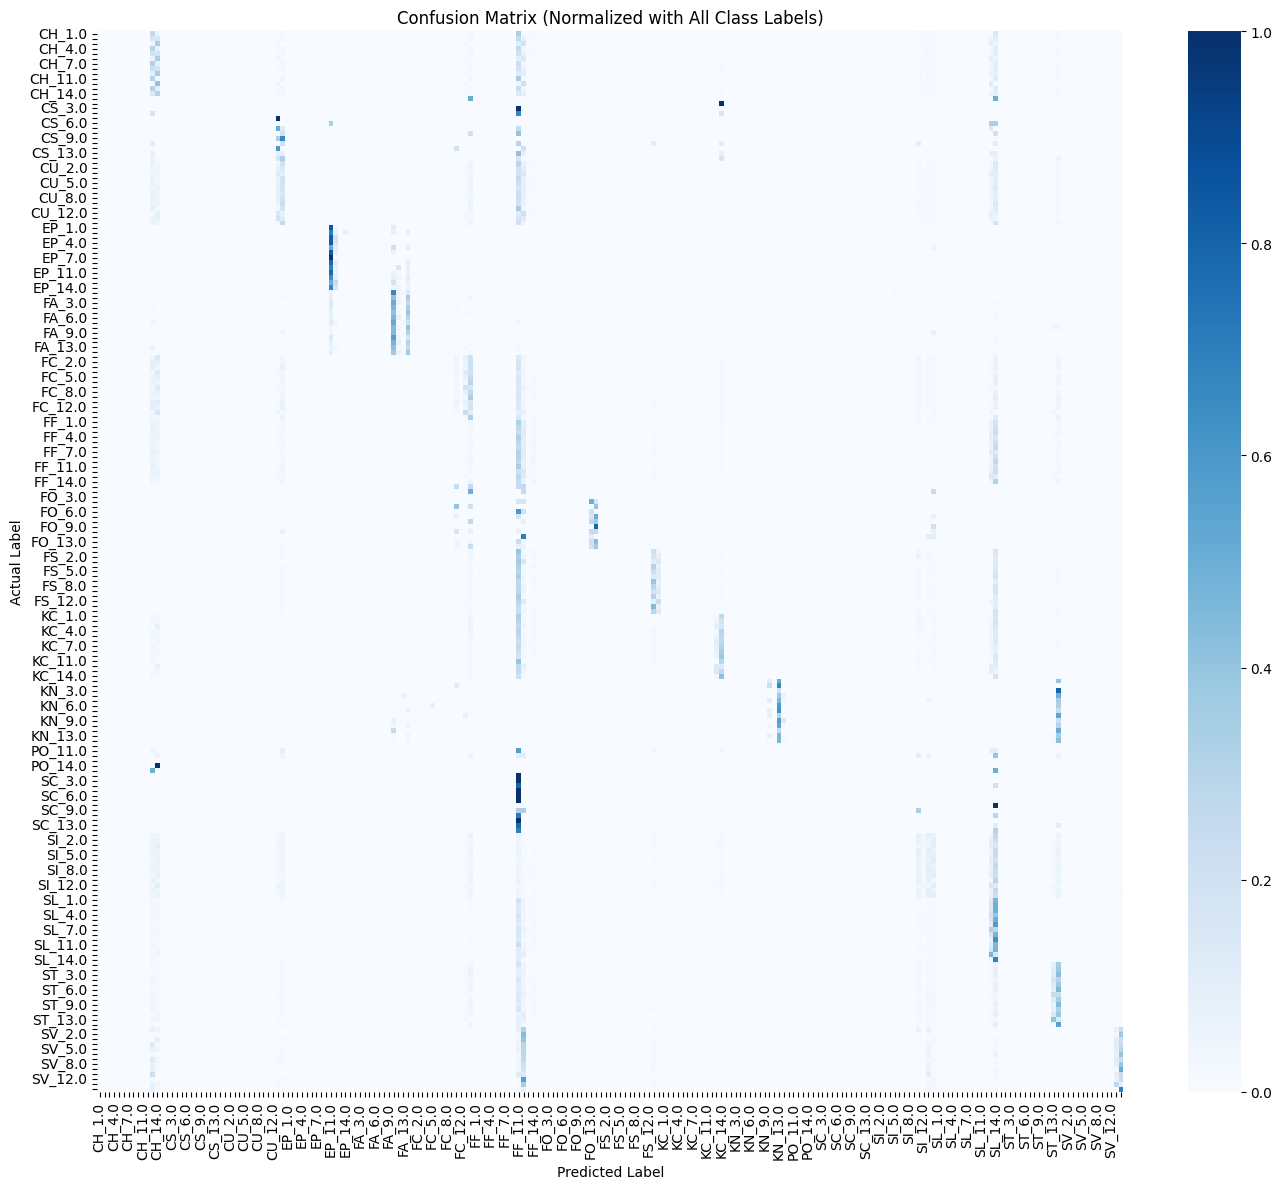

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = torch.argmax(model.predict_proba(X_val), dim=1)

# 1. 予測と正解ラベルをクラス名に戻す
y_val_labels = target_encoder.inverse_transform(y_val.numpy())
y_pred_labels = target_encoder.inverse_transform(y_pred.numpy())
class_names = target_encoder.classes_

# 2. 混同行列を構築（すべてのクラスを対象に）


cm = confusion_matrix(y_val_labels, y_pred_labels, labels=class_names, normalize='true')

# 3. クラス名を並べ替え（例: pitch_zone の数値部分でソート）
def extract_pitch_and_zone(label):
    try:
        pitch, zone = label.split('_')
        return (pitch, float(zone))
    except:
        return (label, 0.0)

sorted_labels = sorted(class_names, key=extract_pitch_and_zone)

# 4. 並び替え用のインデックス
label_to_index = {label: i for i, label in enumerate(class_names)}
sorted_indices = [label_to_index[label] for label in sorted_labels]

# 5. 並び替え後の混同行列
cm_sorted = cm[np.ix_(sorted_indices, sorted_indices)]

# 6. 可視化（目盛りは間引き）
step = 3  # 10個に1つだけ表示
xticks = [label if i % step == 0 else '' for i, label in enumerate(sorted_labels)]
yticks = [label if i % step == 0 else '' for i, label in enumerate(sorted_labels)]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_sorted, xticklabels=xticks, yticklabels=yticks, cmap='Blues', annot=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix (Normalized with All Class Labels)')
plt.tight_layout()
plt.show()


In [7]:
!pip install torchmetrics


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 KB 29.4 MB/s eta 0:00:00


In [48]:
from torchmetrics.functional import accuracy

topk_acc = accuracy(
    preds=model.predict_proba(X_val),
    target=y_val,
    top_k=3,
    task="multiclass",
    num_classes=num_classes
)

print(f"Top-3 Accuracy: {topk_acc:.4f}")


Top-3 Accuracy: 0.2669


In [49]:
from torchmetrics.functional import accuracy

topk_acc = accuracy(
    preds=model.predict_proba(X_val),
    target=y_val,
    top_k=5,
    task="multiclass",
    num_classes=num_classes
)

print(f"Top-5 Accuracy: {topk_acc:.4f}")


Top-5 Accuracy: 0.3658


In [50]:
# 正解と予測をデコード（文字列に戻す）
true_labels = target_encoder.inverse_transform(y_val.numpy())
pred_labels = target_encoder.inverse_transform(val_preds.numpy())

# 分割して判定（球種 or ゾーン どちらか一致なら OK）
correct = 0
for true, pred in zip(true_labels, pred_labels):
    true_pitch, true_zone = true.split("_")
    pred_pitch, pred_zone = pred.split("_")
    if true_pitch == pred_pitch or true_zone == pred_zone:
        correct += 1

# 精度を計算
acc_either = correct / len(true_labels)
print(f"✅ 球種またはゾーン一致の正解率: {acc_either:.4f}")


✅ 球種またはゾーン一致の正解率: 0.5096


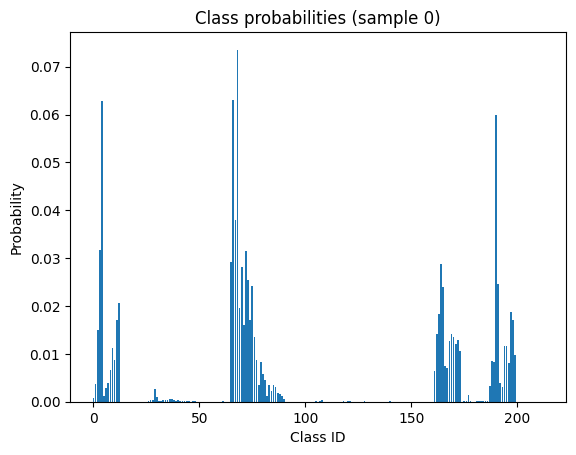

In [42]:
import matplotlib.pyplot as plt

probs = model.predict_proba(X_val)
sample_id = 0  # 任意のサンプル

# 勾配追跡を切ってから NumPy 変換
plt.bar(range(num_classes), probs[sample_id].detach().numpy())
plt.title("Class probabilities (sample 0)")
plt.xlabel("Class ID")
plt.ylabel("Probability")
plt.show()


/home/2025/gawa/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


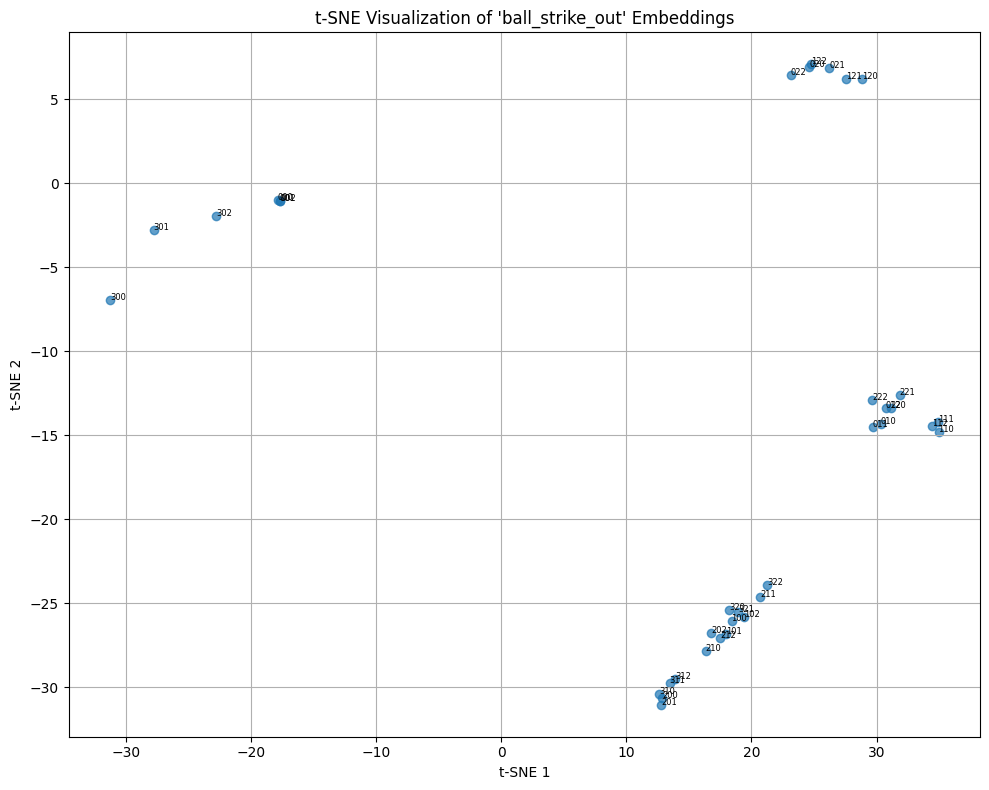

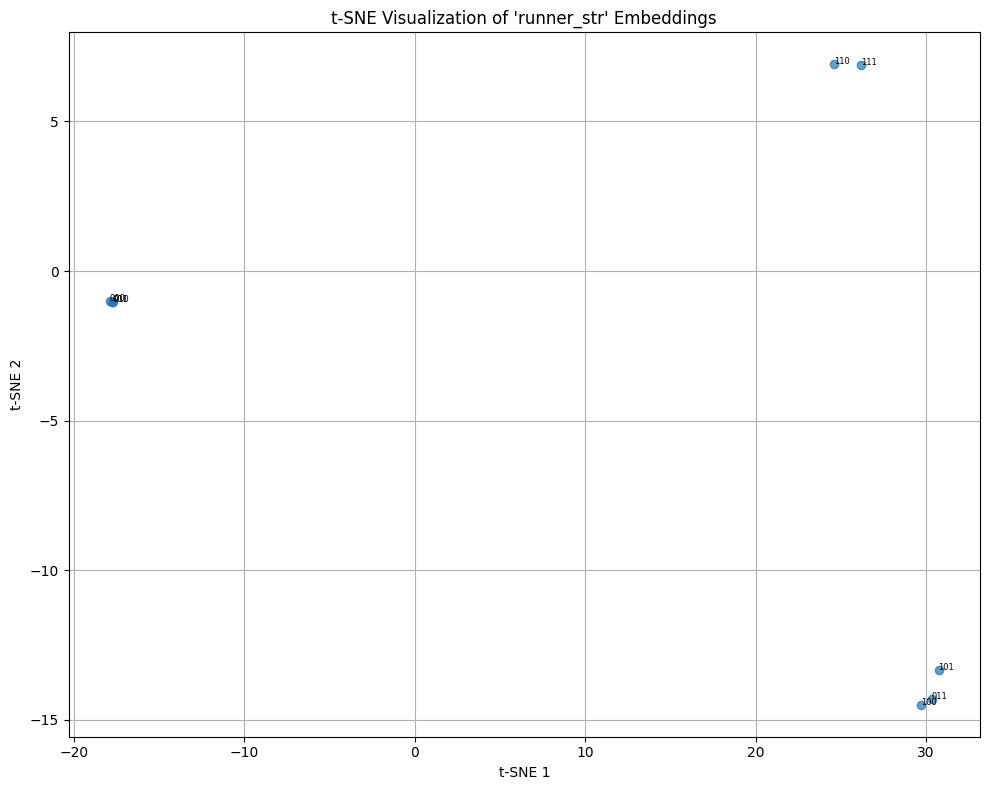

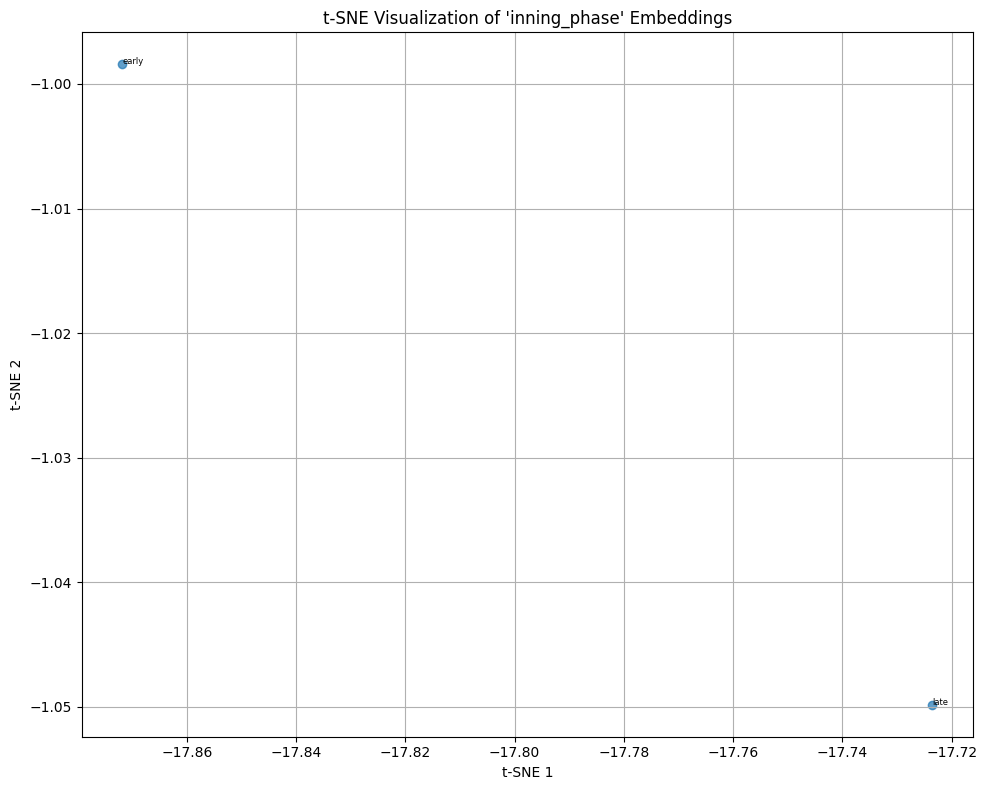

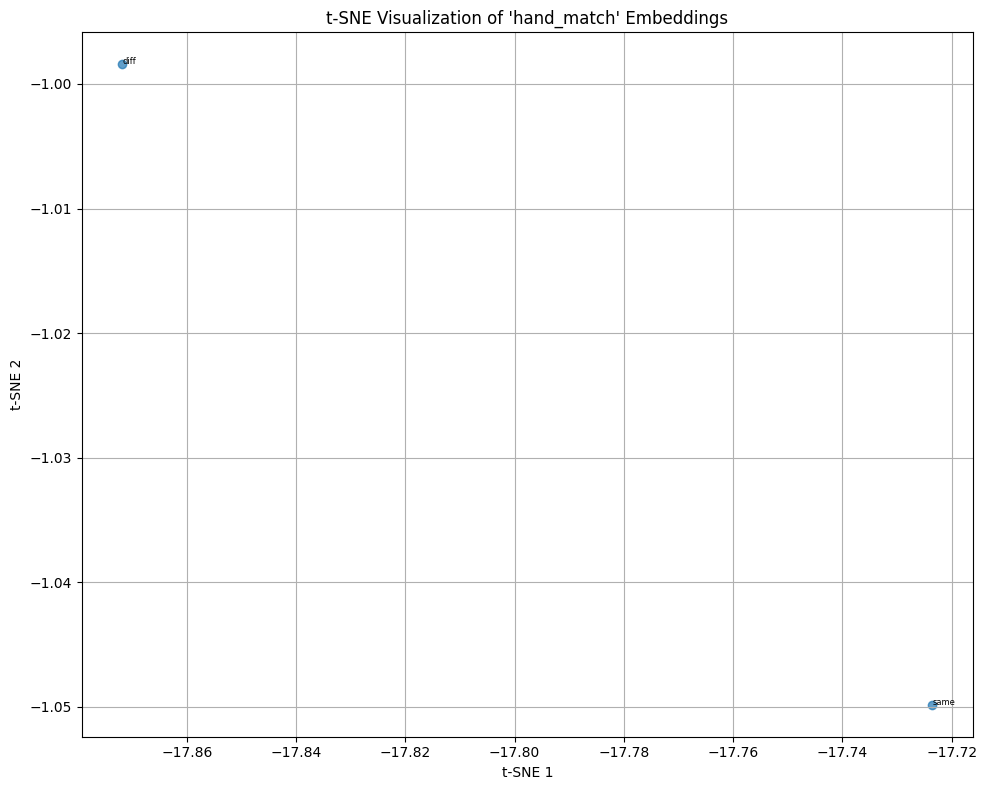

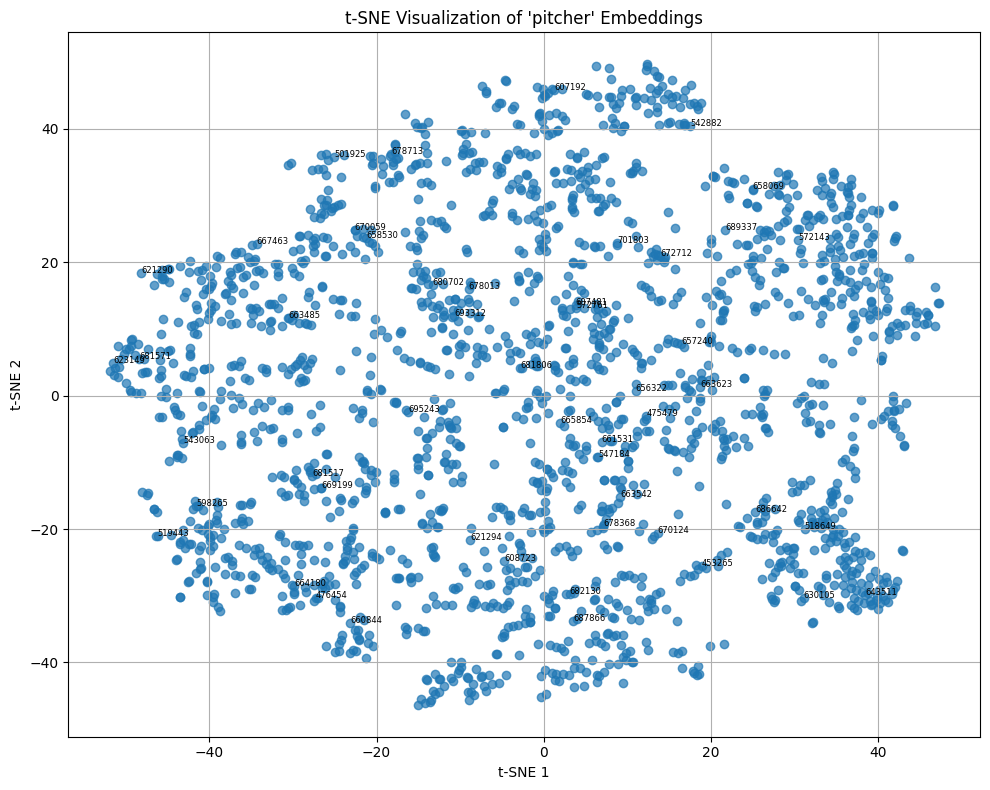

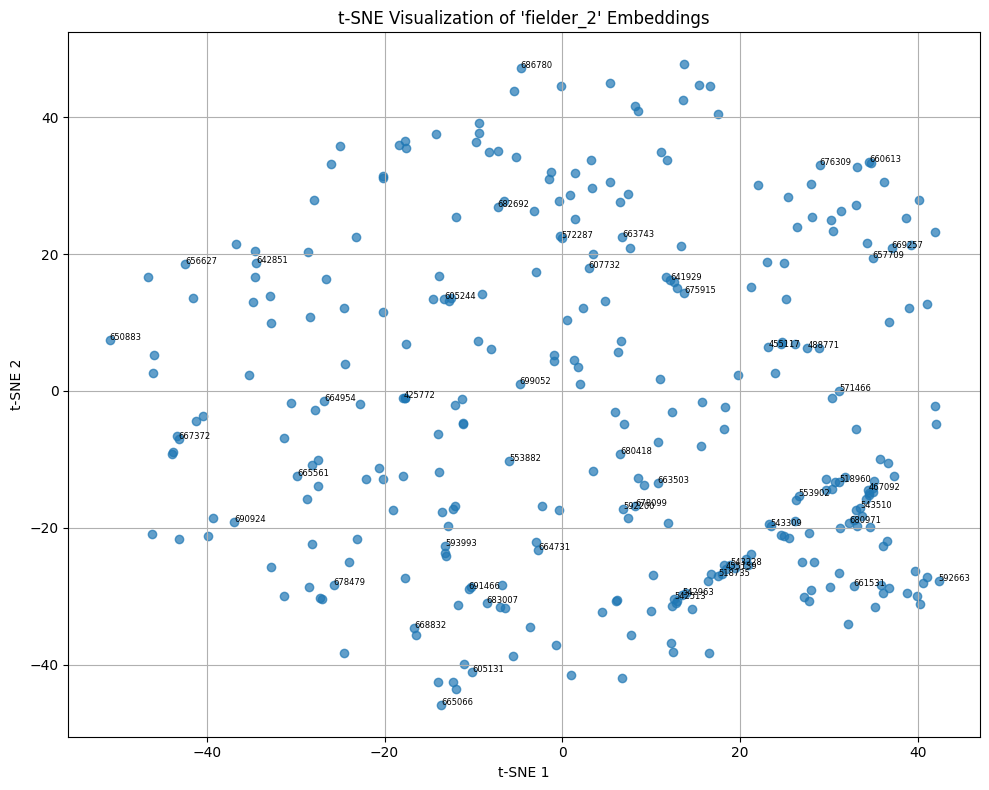

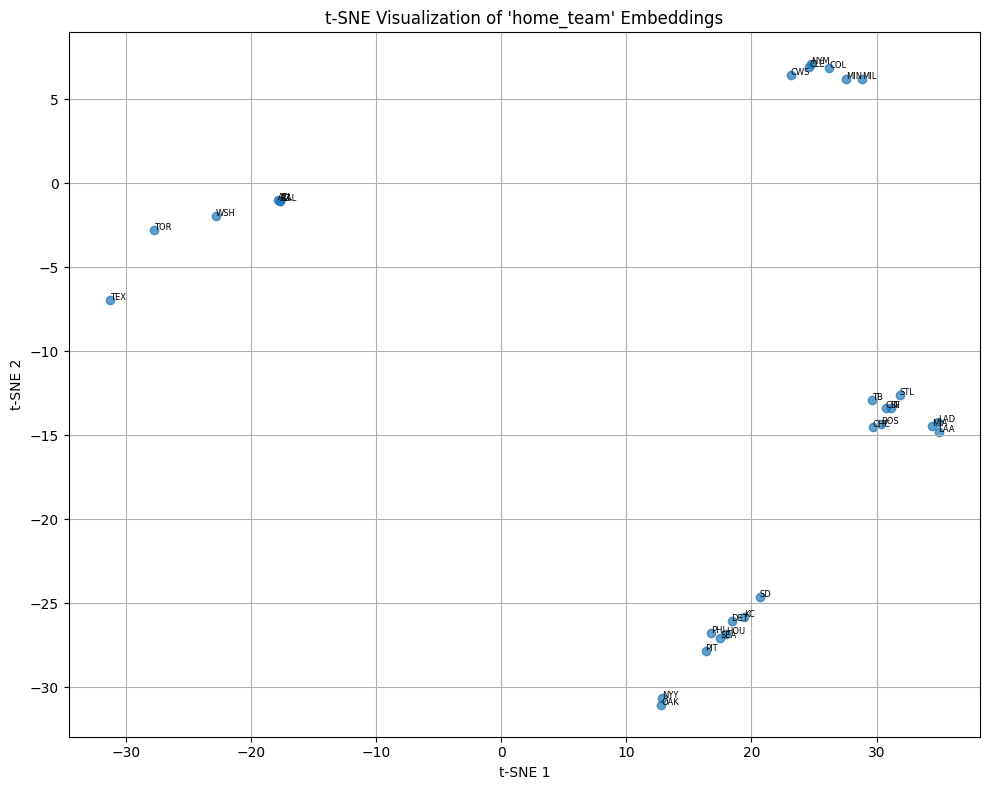

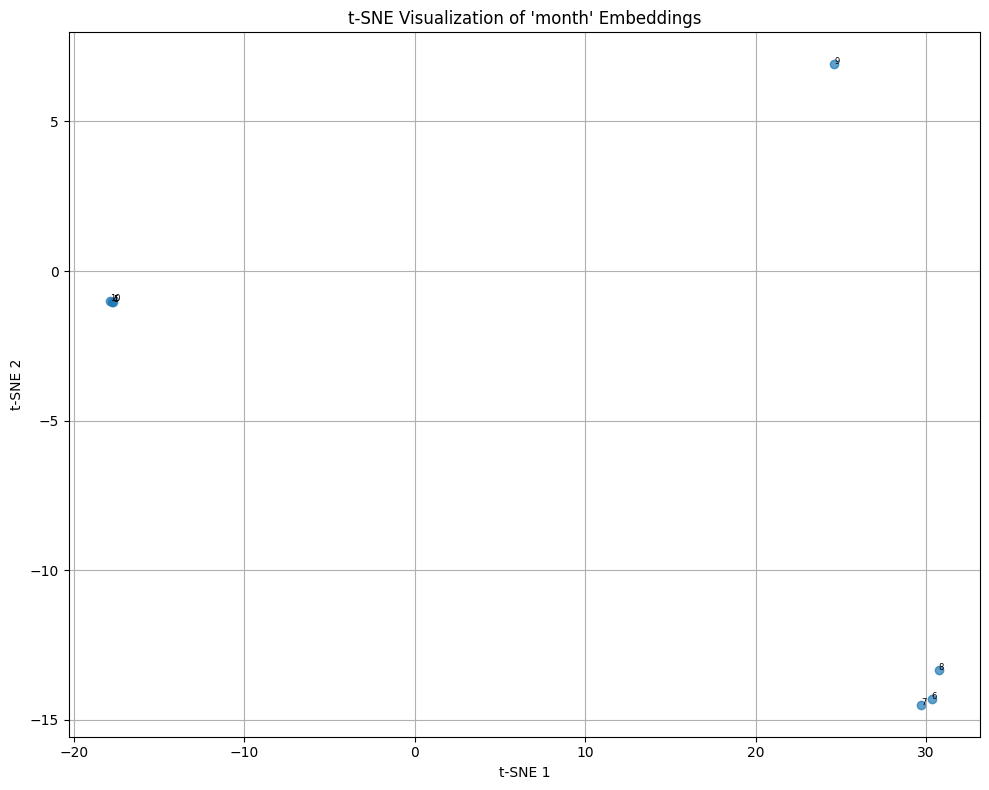

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# --- データ読み込み ---
embedding_df = pd.read_csv("trained_entity_embeddings_nomal.csv", index_col=0)
embedding_df = embedding_df.rename_axis('feature_class').reset_index()

# --- feature名とクラス番号を分離 ---
embedding_df[['feature', 'class']] = embedding_df['feature_class'].str.extract(r'^(.+)_([0-9]+)$')
embedding_df['class'] = embedding_df['class'].astype(int)

# --- エンコードラベル → 元のラベルに変換 ---
with open("label_encoders_embed_final_a_prev.pkl", "rb") as f:
    label_encoders = pickle.load(f)

embedding_df['original_label'] = embedding_df.apply(
    lambda row: label_encoders[row['feature']].inverse_transform([row['class']])[0]
    if row['feature'] in label_encoders else str(row['class']),
    axis=1
)

# --- 埋め込みベクトル取り出し ---
embedding_vectors = embedding_df.iloc[:, 1:-3].apply(pd.to_numeric, errors='coerce').fillna(0).values
if embedding_vectors.shape[1] == 1:
    embedding_vectors = np.hstack([embedding_vectors, np.zeros((embedding_vectors.shape[0], 1))])

# --- t-SNE 次元削減 ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(embedding_vectors)

# --- 散布図（カテゴリごとに） ---
features = embedding_df['feature'].unique()

for feature in features:
    subset = embedding_df[embedding_df['feature'] == feature].copy().reset_index(drop=True)
    coords = X_tsne[subset.index]

    plt.figure(figsize=(10, 8))
    plt.scatter(coords[:, 0], coords[:, 1], alpha=0.7)

    if feature in ['pitcher', 'fielder_2']:
        # ラベルをランダムに50件だけ表示
        n = min(50, len(subset))
        sampled_idx = np.random.choice(len(subset), size=n, replace=False)
        for i in sampled_idx:
            plt.text(coords[i, 0], coords[i, 1], str(subset.loc[i, 'original_label']), fontsize=6)
    else:
        # その他はすべて表示
        for i, row in subset.iterrows():
            plt.text(coords[i, 0], coords[i, 1], str(row['original_label']), fontsize=6)

    plt.title(f"t-SNE Visualization of '{feature}' Embeddings")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


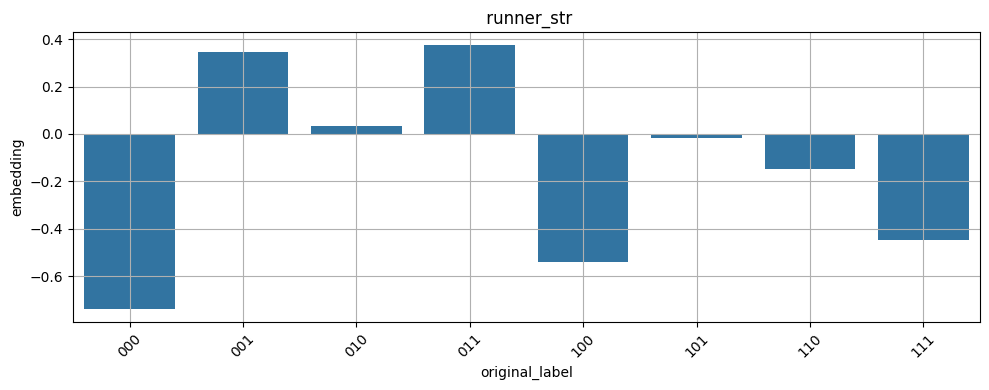

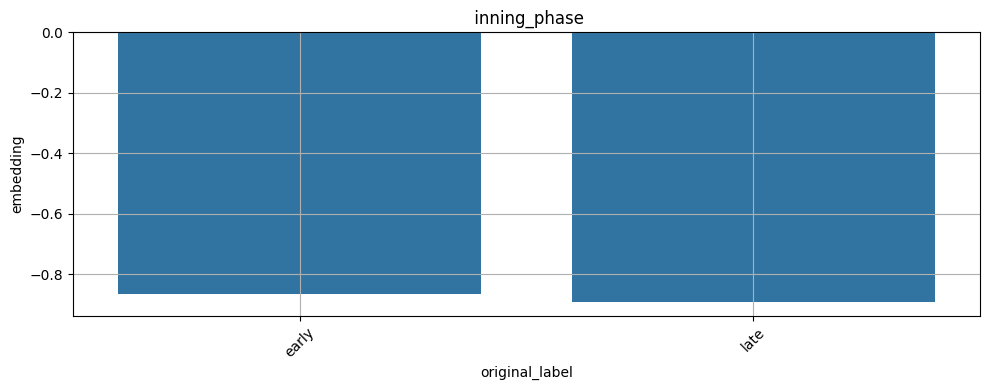

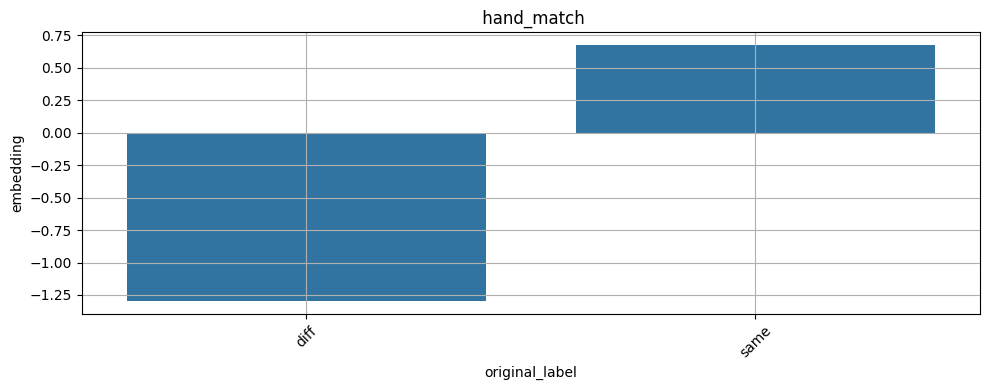

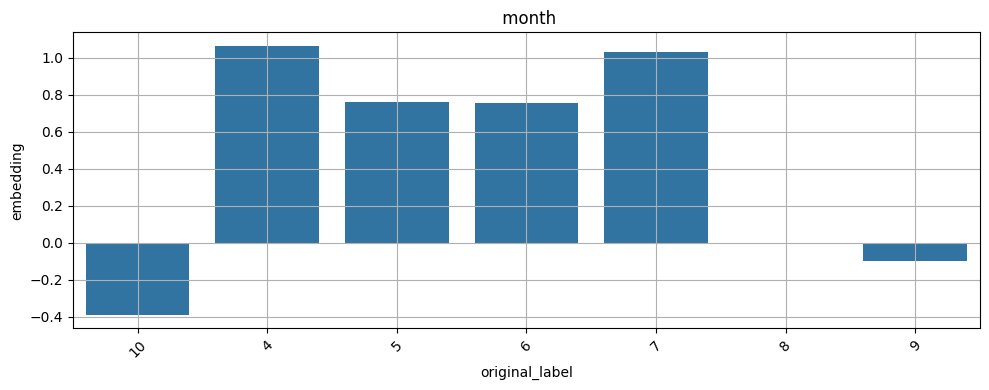

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# --- 埋め込みデータ読み込み ---
embedding_df = pd.read_csv("trained_entity_embeddings_nomal.csv", index_col=0)
embedding_df = embedding_df.rename_axis('feature_class').reset_index()

# --- feature名とクラス番号を分離 ---
embedding_df[['feature', 'class']] = embedding_df['feature_class'].str.extract(r'^(.+)_([0-9]+)$')
embedding_df['class'] = embedding_df['class'].astype(int)

# --- ラベル復元 ---
with open("label_encoders_embed_final_a_prev.pkl", "rb") as f:
    label_encoders = pickle.load(f)

embedding_df['original_label'] = embedding_df.apply(
    lambda row: label_encoders[row['feature']].inverse_transform([row['class']])[0]
    if row['feature'] in label_encoders else str(row['class']),
    axis=1
)

# --- 可視化対象（1次元ベクトル） ---
target_features = ['runner_str', 'inning_phase', 'hand_match', 'month']

for feature in target_features:
    subset = embedding_df[embedding_df['feature'] == feature].copy()
    subset['embedding'] = subset['0'].astype(float)  # 1次元ベクトル

    plt.figure(figsize=(10, 4))
    sns.barplot(x='original_label', y='embedding', data=subset)
    plt.title(f" {feature}")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
